In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multinomial
from sklearn.cluster import KMeans as km

In [2]:
def plot_hw_model(X, n, pi, mu, sigma):
    ax = plt.subplots(figsize = (6,6))[1]
    plt.hist(X, alpha = 0.20, bins = max(X), color = 'grey', edgecolor = 'white', linewidth = 3)

    curve2 = np.linspace(mu[0] - 10 * sigma[0], mu[0] + 10 * sigma[0], 1000)
    curve3 = np.linspace(mu[1] - 10 * sigma[1], mu[1] + 10 * sigma[1], 1000)
    plt.plot(curve2, n * norm.pdf(curve2, mu[0], sigma[0]) * pi[1], linewidth = 3, color='red')
    plt.plot(curve3, n * norm.pdf(curve3, mu[1], sigma[1]) * pi[2], linewidth = 3, color='red')
    plt.scatter(0, n * pi[0], color = 'red')

    ax.set_yscale("log") 
    ax.set_ylim(bottom=1)
    ax.set_xlim(left=0)
    plt.xlabel('Evidence Depth')
    plt.ylabel('Number of Samples')
    plt.show()

In [3]:
def model_hw(X):

    n = np.shape(X)[0] # length of data set
    pi = [1.0/3 for _ in range(3)] # initial mixing coefficients
    r = np.zeros([3,n]) # initial responsibility matrix
    sigma = [np.std(X), np.std(X)] # initial standard deviation for normals
    f = np.ravel(X).astype(float)
    f=f.reshape(-1,1)
    kmeans = km(n_init='auto',n_clusters=3) # k-means for initial means
    kmeans.fit(f)
    centers = np.sort(np.ravel(kmeans.cluster_centers_))
    centers = np.delete(centers, 0) # care about modes 2 and 3
    mu = centers
    log_likelihoods = [] 
    distances = [] # distances between log-likelihoods
    iteration = 0
    distance = 1

    while distance > (1/(n*10)): # tolerance

        # expectation
        r[0][X==0] = pi[0] # responsibility towards first component is just the zeros
        r[0][X!=0] = 0
        r[1] = pi[1] * norm.pdf(X, mu[0], sigma[0]) # responsibility of each value to second component
        r[2] = pi[2] * norm.pdf(X, mu[1], sigma[1]) # responsibility of each value to third component
        r = r / np.sum(r, axis = 0) # normalization

        # maximization
        pi = np.sum(r, axis = 1) / n # total responsibility of a component divided by total # of observations
        for i, pi_i in enumerate(pi):
            if pi_i < 0.01:
                pi[i] = 0.01
        mu[0] = np.average(X, weights = r[1]) # MLE for mean in normal distribution
        mu[1] = np.average(X, weights = r[2]) # MLE for mean in normal distribution
        mu[0] = (mu[0] + 0.5*mu[1])/2 # fixing 2mu_2 = mu_3
        mu[1] = 2*mu[0]
        for i, mu_i in enumerate(mu):
            if mu_i < 0.01:
                mu[i] = 0.01
        sigma[0] = np.average((X-mu[0])**2, weights=r[1])**.5 # MLE for standard deviation in normal distribution
        sigma[1] = np.average((X-mu[1])**2, weights=r[2])**.5 # MLE for standard deviation in normal distribution
        for i, sigma_i in enumerate(sigma):
            if sigma_i < 0.01:
                sigma[i] = 0.01

        # score
        hurdle = np.where(X == 0, pi[0], 0) #  likelihood of each observation in hurdle model
        gmm = pi[1] * norm.pdf(X, mu[0], sigma[0]) +  pi[2] * norm.pdf(X, mu[1], sigma[1])# likelihood of each observation in normal distribution
        log_likelihood = np.sum(np.log(hurdle + gmm)) # sum of log of likelihood of each observation
        log_likelihoods.append(log_likelihood) 

        iteration += 1
        if iteration > 1:
            distance = np.abs(log_likelihoods[-2]-log_likelihoods[-1]) # magnitude of difference between each 
            distances.append(distance)

    return pi, mu, sigma, log_likelihood

In [4]:
def theta_to_data(N, pi, mu_2, sigma):

    draws = multinomial.rvs(n = N, p = pi)

    X = [0 for _ in range(draws[0])]
    X_g = norm.rvs(mu_2, sigma[0], size = draws[1])
    X_g2 = norm.rvs(2 * mu_2, sigma[1], size = draws[2])

    while sum(X_g < -0.5) > 0:
        X_g_new = norm.rvs(mu_2, sigma[0], size = sum(X_g < -0.5))
        X_g = [x for x in X_g if x >= -0.5]
        X_g = np.concatenate((X_g, X_g_new))

    while sum(X_g2 < -0.5) > 0:
        X_g2_new = norm.rvs(2 * mu_2, sigma[1], size = sum(X_g2 < -0.5))
        X_g2 = [x for x in X_g2 if x >= -0.5]
        X_g2 = np.concatenate((X_g2, X_g2_new))

    X = np.concatenate((X,X_g))
    X = np.concatenate((X,X_g2))
    X = np.round(X).astype(int)

    return X

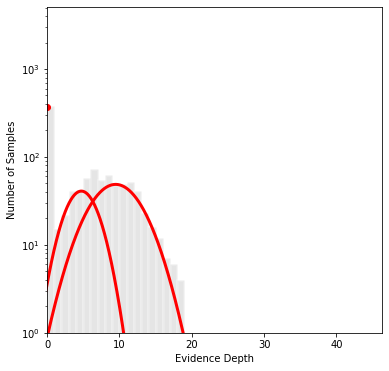

In [5]:
N = 1000
pi = [1/3, 1/3, 1/3]
mu_2 = 5
sigma = [3, 3]

X = theta_to_data(N, pi, mu_2, sigma)

pi_hat, mu_hat, sigma_hat, log_likelihood = model_hw(X)
plot_hw_model(X, N, pi_hat, mu_hat, sigma_hat)